In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

import torch

from ultralytics import YOLOE
from ultralytics.models.yolo.yoloe import YOLOEVPSegPredictor, YOLOEVPDetectPredictor


In [2]:
# Initialize a YOLOE segmentation model
model = YOLOE("yoloe-11s-seg.pt").to("cpu")

100%|██████████| 26.5M/26.5M [00:00<00:00, 44.4MB/s]


In [3]:
model.device

device(type='cpu')

In [4]:
# --- Step 1: Define prompts for reference images ---
# Prompts for the first reference image
visual_prompts_1 = dict(
    bboxes=np.array(
        [
            [215, 392, 350, 864],  # Box enclosing person
        ],
    ),
    cls=np.array(
        [
            0,  # ID to be assigned for person
        ]
    ),
)

# Prompts for a second reference image (using bus.jpg again for simplicity)
visual_prompts_2 = dict(
    bboxes=np.array(
        [
            [41, 391, 246, 905],  # Box enclosing person
        ],
    ),
    cls=np.array(
        [
            0,  # ID to be assigned for person
        ]
    ),
)

# # Prompts for a second reference image (using bus.jpg again for simplicity)
visual_prompts_3 = dict(
    bboxes=np.array(
        [
            [1, 535, 82, 879],  # Box enclosing person
        ],
    ),
    cls=np.array(
        [
            0,  # ID to be assigned for person
        ]
    ),
)

# Prompts for a second reference image (using bus.jpg again for simplicity)
visual_prompts_4 = dict(
    bboxes=np.array(
        [
            [666, 385, 807, 875],  # Box enclosing person
        ],
    ),
    cls=np.array(
        [
            0,  # ID to be assigned for person
        ]
    ),
)

In [5]:
model.device

device(type='cpu')

In [6]:
# --- Step 2: Manually create a predictor instance ---
results = model.predict(
    "bus.jpg",
    visual_prompts=visual_prompts_1,
    predictor=YOLOEVPSegPredictor,
    device="cpu"
)

results[0].show()

Ultralytics 8.3.156  Python-3.10.15 torch-2.7.1+cpu CPU (11th Gen Intel Core(TM) i7-1185G7 3.00GHz)
YOLOe-11s-seg summary (fused): 137 layers, 13,693,398 parameters, 1,857,958 gradients

image 1/1 c:\Users\jordan.pierce\Documents\GitHub\CoralNet-Toolbox\notebooks\bus.jpg: 640x480 3 object0s, 386.2ms
Speed: 6.8ms preprocess, 386.2ms inference, 3525.9ms postprocess per image at shape (1, 3, 640, 480)


In [ ]:
results[0].boxes

In [ ]:
type(model), type(model.predictor)

In [7]:
predictor = YOLOEVPSegPredictor()
predictor.setup_model("yoloe-11s-seg.pt")

Ultralytics 8.3.156  Python-3.10.15 torch-2.7.1+cpu CPU (11th Gen Intel Core(TM) i7-1185G7 3.00GHz)
YOLOe-11s-seg summary (fused): 137 layers, 13,693,398 parameters, 1,857,958 gradients, 36.4 GFLOPs


In [8]:
predictor.set_prompts([])

In [ ]:
predictor.model

In [10]:
# --- Step 3: Generate and collect VPEs from reference images ---
import time

vpe_list = []
print("Generating VPEs from reference images...")

# Generate VPE for the first image
start = time.time()
model.predictor.set_prompts(visual_prompts_1)
vpe1 = model.predictor.get_vpe("bus.jpg")
elapsed = time.time() - start
vpe_list.append(vpe1)
print(f"Generated VPE from the first prompt. Time: {elapsed:.3f} s")

# Generate VPE for the second image
start = time.time()
model.predictor.set_prompts(visual_prompts_2)
vpe2 = model.predictor.get_vpe("bus.jpg")
elapsed = time.time() - start
vpe_list.append(vpe2)
print(f"Generated VPE from the second prompt. Time: {elapsed:.3f} s")

# Generate VPE for the third image
start = time.time()
model.predictor.set_prompts(visual_prompts_3)
vpe3 = model.predictor.get_vpe("bus.jpg")
elapsed = time.time() - start
vpe_list.append(vpe3)
print(f"Generated VPE from the third prompt. Time: {elapsed:.3f} s")

# Generate VPE for the fourth image
start = time.time()
model.predictor.set_prompts(visual_prompts_4)
vpe4 = model.predictor.get_vpe("bus.jpg")
elapsed = time.time() - start
vpe_list.append(vpe4)
print(f"Generated VPE from the fourth prompt. Time: {elapsed:.3f} s")

Generating VPEs from reference images...
Generated VPE from the first prompt. Time: 0.294 s
Generated VPE from the second prompt. Time: 0.167 s
Generated VPE from the third prompt. Time: 0.205 s
Generated VPE from the fourth prompt. Time: 0.173 s


In [ ]:
type(model), type(model.predictor)

In [11]:
# --- Step 4: Aggregate the VPEs ---
# Combine the list of VPE tensors and average them
final_vpe = torch.cat(vpe_list).mean(dim=0, keepdim=True)

# Normalize the final embedding
final_vpe = torch.nn.functional.normalize(final_vpe, p=2, dim=-1)
print("\nSuccessfully combined VPEs into a single, normalized embedding.")


Successfully combined VPEs into a single, normalized embedding.


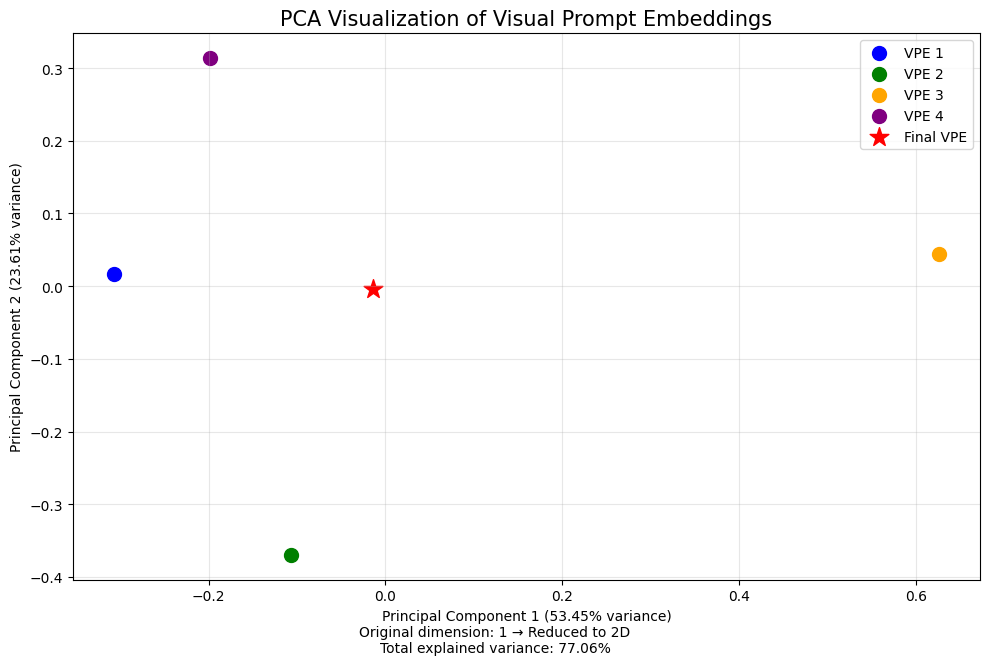

In [12]:
# --- Step 5: Visualize VPEs using PCA ---

# Convert tensors to numpy arrays for PCA
vpe_arrays = [vpe.detach().cpu().numpy().squeeze() for vpe in vpe_list]
final_vpe_array = final_vpe.detach().cpu().numpy().squeeze()

# Stack all embeddings for PCA
all_vpes = np.vstack(vpe_arrays + [final_vpe_array])

# Apply PCA to reduce to 2 dimensions
pca = PCA(n_components=2)
vpes_2d = pca.fit_transform(all_vpes)

# Create a simple scatter plot
plt.figure(figsize=(10, 7))

# Plot individual VPEs
plt.scatter(vpes_2d[0, 0], vpes_2d[0, 1], color='blue', s=100, label='VPE 1')
plt.scatter(vpes_2d[1, 0], vpes_2d[1, 1], color='green', s=100, label='VPE 2')
plt.scatter(vpes_2d[2, 0], vpes_2d[2, 1], color='orange', s=100, label='VPE 3')
plt.scatter(vpes_2d[3, 0], vpes_2d[3, 1], color='purple', s=100, label='VPE 4')

# Plot the final (averaged) VPE
plt.scatter(vpes_2d[4, 0], vpes_2d[4, 1], color='red', s=200, marker='*', label='Final VPE')

# Add labels and information
plt.title('PCA Visualization of Visual Prompt Embeddings', fontsize=15)
plt.xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.grid(alpha=0.3)
plt.legend()

# Add a text annotation with information about the original dimensionality
orig_dim = vpe_list[0].shape[1]
plt.figtext(0.5, 0.01, 
            f"Original dimension: {orig_dim} → Reduced to 2D\n"
            f"Total explained variance: {sum(pca.explained_variance_ratio_):.2%}",
            ha='center')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to accommodate the text
plt.show()

In [13]:
# --- Step 6: Run inference using the aggregated VPE ---

# Directly set the final tensor as the prompt for the predictor.
# The `inference` method is designed to use this tensor.
model.is_fused = lambda: False
model.set_classes(["person"], final_vpe)

In [14]:
type(model), type(model.predictor)

(ultralytics.models.yolo.model.YOLOE,
 ultralytics.models.yolo.yoloe.predict.YOLOEVPSegPredictor)

In [16]:
results = model.predict("zidane.jpg",
                visual_prompts=[])

print("Inference complete. Results are generated.")
# You can now process or display the 'results'.
results[0].show()

Ultralytics 8.3.156  Python-3.10.15 torch-2.7.1+cpu CPU (11th Gen Intel Core(TM) i7-1185G7 3.00GHz)

image 1/1 c:\Users\jordan.pierce\Documents\GitHub\CoralNet-Toolbox\notebooks\zidane.jpg: 384x640 1 person, 327.4ms
Speed: 1.4ms preprocess, 327.4ms inference, 5.9ms postprocess per image at shape (1, 3, 384, 640)
Inference complete. Results are generated.


In [ ]:
# After the model is used with .predict, it's predictor is no longer a YOLOEVPSegPredictor!
type(model), type(model.predictor)

In [ ]:
results = model.predict("bus.jpg")

print("Inference complete. Results are generated.")
# You can now process or display the 'results'.
results[0].show()


In [ ]:
type(model), type(model.predictor)

In [ ]:
results = model.predict("people_1.jpg")

print("Inference complete. Results are generated.")
# You can now process or display the 'results'.
results[0].show()


In [ ]:
type(model), type(model.predictor)

### Exporting Final VPEs and Re-importing

In [ ]:
final_vpe

In [ ]:
# Export the final_vpe tensor to disk

# Move to CPU before saving to ensure compatibility when loading
final_vpe_cpu = final_vpe.cpu()

# Save the tensor
torch.save(final_vpe_cpu, "vpe.pt")
print(f"Saved VPE tensor to person_vpe.pt")

In [ ]:
# Re-import the VPE tensor
loaded_vpe = torch.load("vpe.pt")

# Move to the appropriate device if needed (e.g., GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loaded_vpe = loaded_vpe.to(device)

print(f"Loaded VPE tensor from disk. Shape: {loaded_vpe.shape}")
print(f"Device: {loaded_vpe.device}")

In [ ]:
# Initialize a YOLOE segmentation model
model_2 = None
model_2 = YOLOE("yoloe-11s-seg.pt")

In [ ]:
# Prompts for the first reference image
visual_prompts_1 = dict(
    bboxes=np.array(
        [
            [215, 392, 350, 864],  # Box enclosing person
        ],
    ),
    cls=np.array(
        [
            0,  # ID to be assigned for person
        ]
    ),
)

In [ ]:
results = model_2.predict(
    "bus.jpg",
    visual_prompts=visual_prompts_1,
    predictor=YOLOEVPSegPredictor,
)

results[0].show()

In [ ]:
# --- Step 6: Run inference using the aggregated VPE ---

# Directly set the final tensor as the prompt for the predictor.
# The `inference` method is designed to use this tensor.
model_2.is_fused = lambda: False
model_2.set_classes(["person"], loaded_vpe)

In [ ]:
results = model_2.predict("bus.jpg",
                          visual_prompts=[],  # Providing new visual prompts this way will overwrite the set VPEs 
                          predictor=YOLOEVPSegPredictor,  # Okay to keep
                          )

print("Inference complete. Results are generated.")
# You can now process or display the 'results'.
results[0].show()


In [ ]:
results = model_2.predict("zidane.jpg",
                          visual_prompts=[],  # Providing new visual prompts this way will overwrite the set VPEs 
                          predictor=YOLOEVPSegPredictor,  # Okay to keep
                          )

print("Inference complete. Results are generated.")
# You can now process or display the 'results'.
results[0].show()


This issue is that each time we want to add new prompts (and calculate VPEs) we also need to re-load the model
using the ad-hoc method shown in the first section. This isn't ideal for interactive model (predictor), but would
work fine for Generator.